# Speeding up multiple requests with httpx and asyncio

An example: fetching S4G decomposition [(Salo et al, 2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....4S/abstract) images from Oulu university website for a list of objects and without waiting for too long.

In [34]:
import requests  # plain old module that everyone uses
import httpx # new asynchronous  version on the same 

In [35]:
from astropy.table import Table
from pathlib import Path
from PIL import Image
from io import BytesIO
import asyncio
import time

## Get a list of objects

In [36]:
def get_objects():
    url = "http://archive.eso.org/wdb/wdb/eso/eso_archive_main/query"
    params = dict(
        wdbo="csv/download",
        max_rows_returned=1000,
        instrument="MUSE",
        prog_id = "0104.B-0404(A)", # Composite Bulges survey
        dp_cat = "SCIENCE",
        dp_type = "OBJECT"
    )
    resp =  httpx.get(url, params=params, timeout=5)
    if resp.is_success: # `ok` in requests
        return Table.read(resp.text, format="ascii.csv", comment="#")
    else:
        resp.raise_for_status()

In [37]:
objects = get_objects()

In [38]:
galaxies = list(objects["OBJECT"])

In [39]:
decompositions_folder = Path("decompositions")
decompositions_folder.mkdir(exist_ok=True)

In [41]:
#galaxies

In [42]:
image_types = {
    "ellipses": lambda g: f"{g}.phot.1_ellipse.jpg",
    "B+D decomposition profile": lambda g: f"FINAL_NS/{g}_bd.outgal_profile.jpg",
    "B+D deprojected": lambda g: f"FINAL_NS/{g}_bd.outgal_components.jpg",
    "B+D+BAR decomposition profile": lambda g: f"FINAL_NS/{g}_bdbar.outgal_profile.jpg",
    "B+D+BAR deprojected": lambda g: f"FINAL_NS/{g}_bdbar.outgal_components.jpg"
}

## Get decompositions using Requests

In [44]:
def get_s4g_decompositions(galaxy, session=None):
    url = "https://www.oulu.fi/astronomy"
    url += f"/S4G_PIPELINE4/P4STORE/{galaxy}/"
    
    result = {}
    if session is None:
        session = requests.Session()
        
    for k, v in image_types.items():
        resp = session.get(url + v(galaxy), timeout=5)
        if resp.ok:
            result[k] = resp.content
    return result

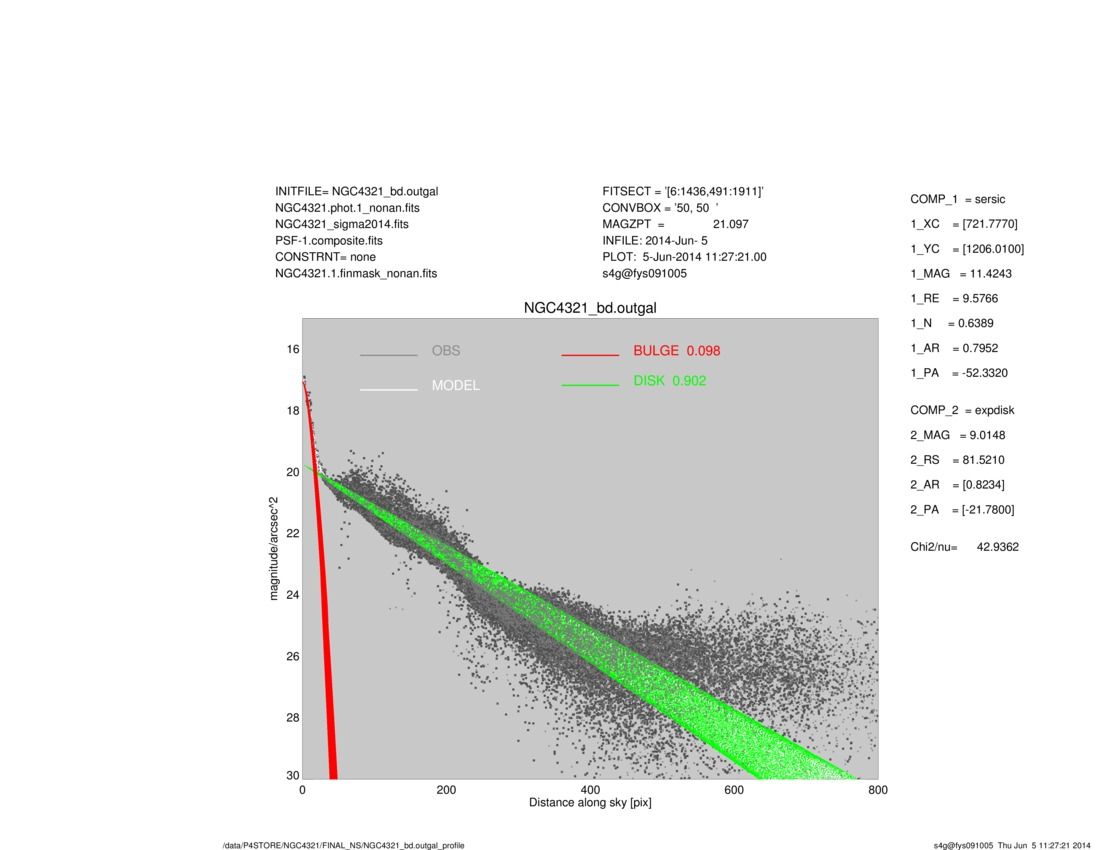

In [51]:
Image.open(
    BytesIO(get_s4g_decompositions(galaxies[1])["B+D decomposition profile"])
)

In [17]:
t1 = time.time()
with requests.Session() as s:
    for g in galaxies:
        gp = decompositions_folder / g
        gp.mkdir(exist_ok=True)
        r = get_s4g_decompositions(g, session=s)
        for k, content in r.items():
            with open(gp / Path(image_types[k](g)).name, "wb") as f:
                f.write(content)
print("elapsed:", time.time() - t1)

elapsed: 17.444342374801636


Let's see how we can speed this up

## Get decompositions using HTTPX (async)

In [19]:
async def get_s4g_decompositions_async(galaxy, client=None):
    url = "https://www.oulu.fi/astronomy"
    url += f"/S4G_PIPELINE4/P4STORE/{galaxy}/"
    
    result = {}
    if client is None:
        client = httpx.AsyncClient()
    
    for k, v in image_types.items():
            resp = await client.get(url + v(galaxy), timeout=5)
            if resp.is_success:
                result[k] = resp.content
    return result

In [20]:
async def process_galaxy(g):
    async with httpx.AsyncClient() as c:
        gp = decompositions_folder / g
        gp.mkdir(exist_ok=True)
        r = await get_s4g_decompositions_async(g, client=c)
        for k, content in r.items():
            with open(gp / Path(image_types[k](g)).name, "wb") as f:
                f.write(content)

In [21]:
async def run_downloads():
    background_tasks = set()
    # better use TaskGroup (python 3.11) or trio (otherwise) for structured concurrency
    await asyncio.gather(*(process_galaxy(g) for g in galaxies))

In [22]:
t1 = time.time()
decompositions_folder.mkdir(exist_ok=True)
# the following is a trick to place a task in jupyter event loop 
# and wait for its completion, normally just asyncio.run(..) would suffice
loop = asyncio.get_event_loop()
task = loop.create_task(run_downloads())
task.add_done_callback(lambda t: print("elapsed:", time.time() - t1))

elapsed: 6.23957085609436
